# 4. Image Convolution

## Table of Contents
1. [Libraries](#libraries)
2. [Simple Example](#simple)
3. [PyTorch Convolution](#pytorch)
4. [Challenge](#challenge)

## **1. Importing Libraries** <a class="anchor" id="libraries" ></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Simple Convolution <a class="anchor" id="simple" ></a>

### Definition

- __I__: Image to convolve.
- __H__: filter matrix to convolve the image with.
- __J__: Result of the convolution.

The following graphics shows exemplary the mathematical operations of the convolution. The filter matrix __H__ is shifted over the input image __I__. The values 'under' the filter matrix are multiplicated with the corresponding values in __H__, summed up and writen to the result __J__. The target position is usually the position under the center of __H__.

![Evidence 3](https://i.imgur.com/AoCuQud.jpg)

In order to implement the convolution with a block filter, we need two methods. The first one will create the block filter matrix __H__ depending on the filter width/height __n__.

A block filter holds the value $\dfrac{1}{n\cdot n}$ at each position:

## **2. Simple Example**

In [2]:
def block_filter(n):
    H = np.ones((n, n)) / (n * n) # each element in H has the value 1/(n*n)
    return H

We will test the method by creating a filter with ``n = 5``:

In [3]:
H = block_filter(5)
print(H)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Next, we define the actual convolution operation. To prevent invalid indices at the border of the image, we introduce the padding __p__.

In [4]:
def apply_filter(I, H):
    h, w = I.shape                         # image dimensions (height, width)
    n = H.shape[0]                         # filter size
    p = n // 2                             # padding size
    J = np.zeros_like(I)                   # output image, initialized with zeros

    for x in range(p, h-p):
        for y in range(p, w-p):
            J[x, y] = np.sum(I[x-p:x+n-p, y-p:y+n-p] * H)
    return J

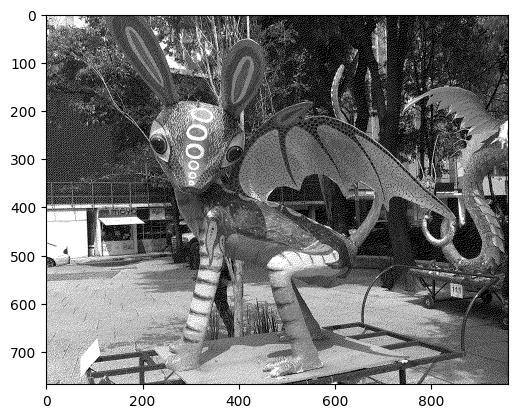

In [5]:
image = Image.open('data/image.jpg')
image = image.convert('1') # convert image to black and white

image = np.array(image)

# image = np.zeros((200, 200), dtype=np.float)
# for x in range(200):
#     for y in range(200):
#         d = ((x-100)**2+(y-100)**2)**0.5
#         image[x, y] = d % 8 < 4

plt.imshow(image, cmap='gray',vmin=0.0, vmax=1.0)
plt.show()

In [6]:
image = image.astype(float)

Next we test our implementation and apply a block filter with size 7

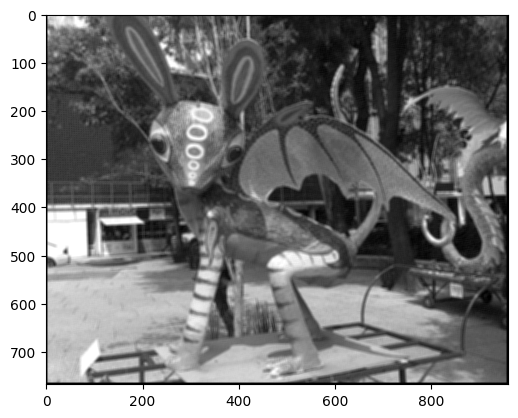

In [7]:
n = 7
H = block_filter(n)
J = apply_filter(image, H)

plt.imshow(J, cmap='gray')
plt.show()

## **3. PyTorch Convolution** <a class="anchor" id="pytorch" ></a>

In [8]:
from PIL import Image

img = Image.open('data/image.jpg')
img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.

<ipython-input-8-7c8c44ebc1df>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((256,256), Image.ANTIALIAS) # Resize to half to reduce the size of this notebook.


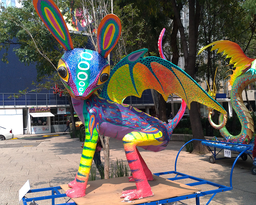

In [9]:
img

In [10]:
import torch, torchvision
from torchvision import transforms
from torch import nn

In [11]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

In [12]:
input = to_tensor(img)
input.shape


torch.Size([1, 205, 256])

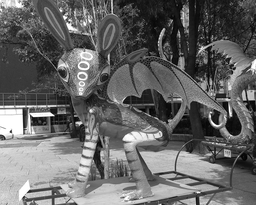

In [13]:
to_pil(input)

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [14]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

In [15]:
# The code below does not work because the convolution layer requires the dimension for batch.
conv(input)

tensor([[[-0.1250, -0.3295, -0.3100,  ..., -0.1069, -0.0855, -0.0574],
         [ 0.4383, -0.0080,  0.0426,  ...,  0.0325, -0.0126, -0.0754],
         [ 0.4643,  0.0153, -0.0275,  ...,  0.0175, -0.0527, -0.0951],
         ...,
         [ 0.3636,  0.0217,  0.0319,  ..., -0.0177, -0.0130, -0.0589],
         [ 0.3518, -0.0241,  0.0391,  ...,  0.0039,  0.0043, -0.0601],
         [ 0.5384,  0.2031,  0.2525,  ...,  0.1198,  0.1051, -0.0032]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [16]:
input = input.unsqueeze(0)
input.shape

torch.Size([1, 1, 205, 256])

In [17]:
output = conv(input)
output.shape

torch.Size([1, 1, 205, 256])

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [18]:
output.shape

torch.Size([1, 1, 205, 256])

We need to remove the first dimension before converting to a PIL object.

In [19]:
output.data.squeeze(dim=0).shape

torch.Size([1, 205, 256])

Display the output from the convolution layer by converting `output` to a PIL object.

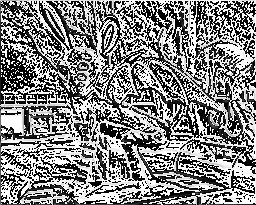

In [20]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

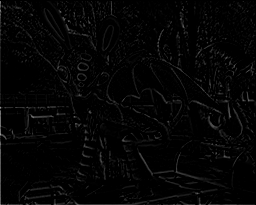

In [21]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

In [22]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

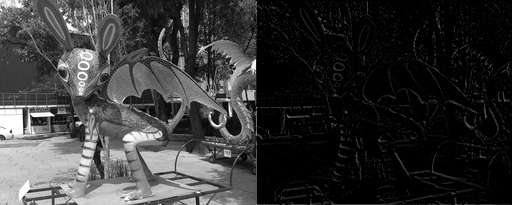

In [23]:
display(input, output)

### Identity

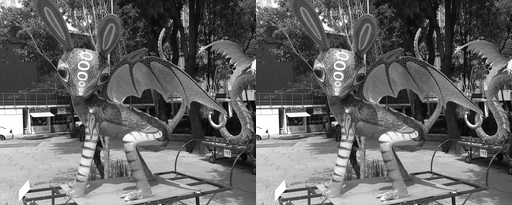

In [24]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

output = conv(input)
display(input, output)

### Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


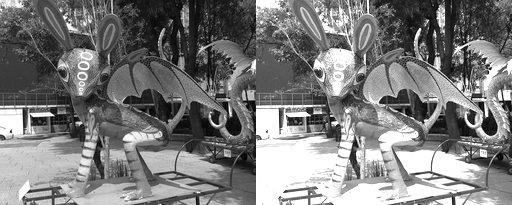

In [25]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


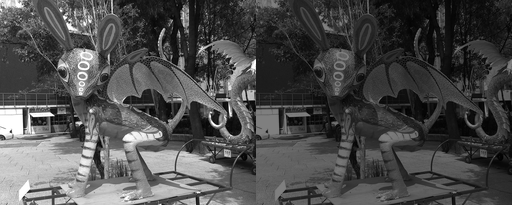

In [26]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


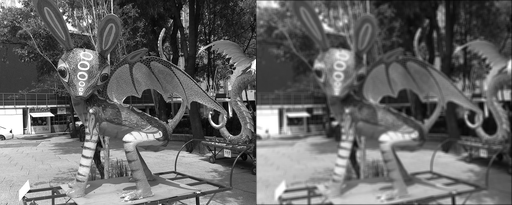

In [27]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


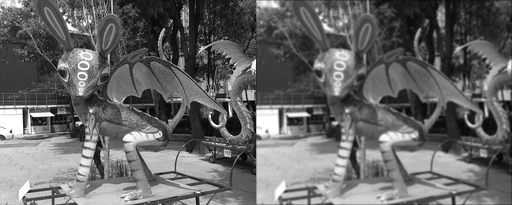

In [28]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

### Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


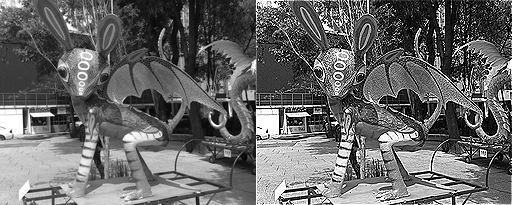

In [29]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


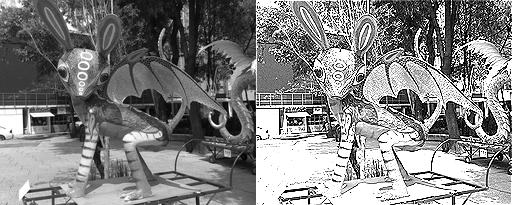

In [30]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

### Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


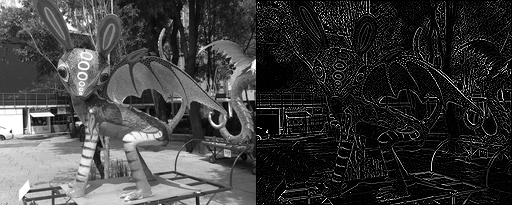

In [31]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

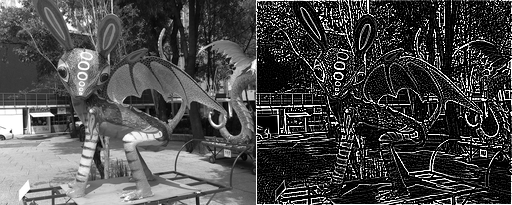

In [32]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)

##**3. Challenge**

#### **1. Prewitt, Sobel y Laplaciano**
> Implementa los detectores de línea siguientes usando código en Python (es decir, sin usar librerías de OpenCV): Prewitt, Sobel y Laplaciano. Investiga la complejidad algoritmica de estos, ¿cuál es más eficiente?

#### **2. Image enhancement and image masking**

> Implementa un algoritmo de realce o mejoramiento de imágenes mediante un algoritmo de en el cual se extraen las líneas de la imagen y después se aplica la diferencia con la imagen original, multiplicando los píxeles de la imagen “máscara” (las líneas encontradas) por un factor alfa mayor a 1.

In [53]:
import cv2
import matplotlib.pyplot as plt

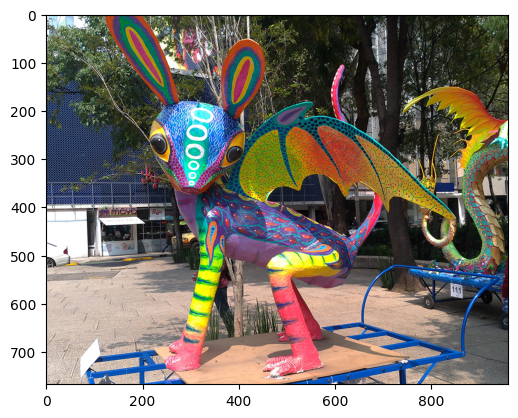

In [52]:
original_image = Image.open('data/image.jpg')
plt.imshow(original_image)
type(original_image)

# Save the image
np.save('data/img.npy', original_image)


Explcation

Procesando imagen...


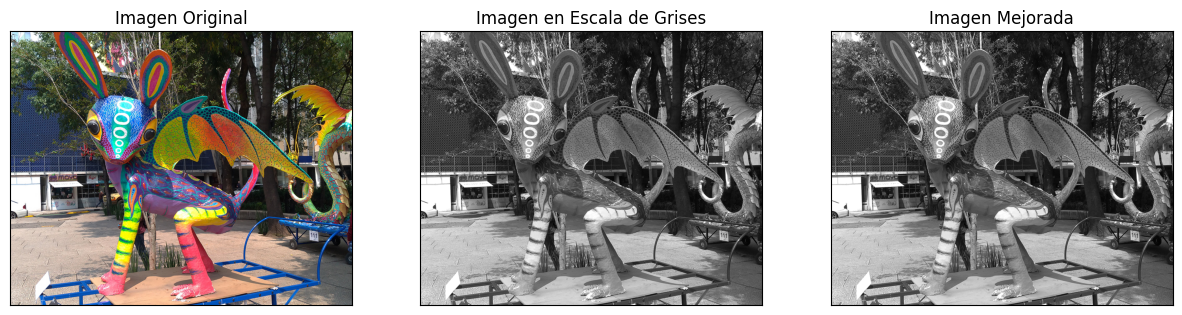

Proceso completado.


In [61]:
def line_enhancement(img, alpha=3):
    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Usar un tamaño de filtro más eficiente para el suavizado
    soften = cv2.medianBlur(gray, 3)

    # Detectar bordes
    edges = cv2.Canny(soften, 80, 200)

    # Crear una máscara y aplicarla
    mask = cv2.subtract(soften, edges)
    enhanced = cv2.addWeighted(gray, alpha, mask, 1-alpha, 0)

    # Mostrar las imágenes
    plot_images_enhanced(img, gray, enhanced)

def plot_images_enhanced(orig_img, gray_img, enhanced_img):
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=([15, 15]))
    plt.subplot(131), plt.imshow(orig_img)
    plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(gray_img, cmap='gray')
    plt.title('Imagen en Escala de Grises'), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(enhanced_img, cmap='gray')
    plt.title('Imagen Mejorada'), plt.xticks([]), plt.yticks([])
    plt.show()

# Cargar y procesar la imagen
img = cv2.imread('data/image.jpg')

if img is None:
    print("Error: no se pudo cargar la imagen. Verifica la ruta del archivo.")
else:
    print("Procesando imagen...")
    line_enhancement(img, 1)
    print("Proceso completado.")